# Purpose of This Notebook
1. Load in the images we took in `01_Collecting_images`
1. Add some data augmentation such as: Zoom, fliping the image, brightness, and rotation to add even more variance to images
1. Do transfer learning on the prebuilt model 
1. Evaluate the model on new unseen images
1. Evaluate the model when passing in images from OpenCv, what will be used to access our webcam

## Table of Content
1. [Imports](#imports)
1. [Set up our training and testing](#setup)
1. [Checking the read in data](#checks)
1. [Running the model](#model)
1. [Evaluating the model](#eval)

<span id = 'imports'></span>
## Imports
`confusion_matrix`: Used to print out the confusion matrix graph seen in the [Evaluting the model](#eval) section  
`classification_report`: Used to get the reports and stats seen above the confusion matrix  
`isfile`, `join`, `listdir`: Used to get the list of file names in a folder  
`sns`:  Used to plot the confusion matrix  
`time`: Used to time how long the model takes to make a prediction  
`plt`: For graphs, and viewing images  
`np`: Used for basic calculations and math functions  
`cv2`: Used to simulate receiving a frame from the webcam as a metric as that will be the final goal  
`ImageDataGenerator`: Used for Data augmentation, seperating the images by folder to get the target, and resize in one step  
`Sequential`: Used for our NN model as it has a step by step layering process  
`load_model`: Used to read back our model  
`ModelCheckpoint`: Used to save our model's best parameters and weights based on a metric we specify  
`MobileNet`: A pretrained model built into keras.applications  
`Adam`: To change our learning rate  
`Dense`: To add in our final layer after the pretrained model  

In [21]:
# Used for metrics and viewing the images
from sklearn.metrics import confusion_matrix, classification_report
from os.path import isfile, join
import matplotlib.pyplot as plt
from os import listdir
import seaborn as sns
import numpy as np
import time
import cv2

# From Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import MobileNet # pretrained model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense

<span id ='setup'></span>
## Setting up the images in our folders 

#### Make get target names from the folders they were saved in as, and make sure pictures are all the same size

In [15]:
rescale = ImageDataGenerator(rescale=1/255, # scaling so everything will be from 0 - 1
                             # Next 4 lines will randomly choose images for data augmentation
                             zoom_range = 0.5,
                             horizontal_flip = True,
                             brightness_range = (0.7, 1.3),
                             rotation_range = 20)

train_set = rescale.flow_from_directory('../imgs/train/',
                                    # MobileNet Excepts a square image with size 224 being the default
                                    target_size=(224, 224),
                                    class_mode='categorical',
                                    batch_size=16)

test_set = rescale.flow_from_directory('../imgs/test/',
                                   target_size=(224, 224),
                                   class_mode='categorical',
                                   batch_size= 16)

input_shape = train_set.image_shape
input_shape

Found 790 images belonging to 6 classes.
Found 144 images belonging to 6 classes.


(224, 224, 3)

<span id ='checks'></span>
## Check out 5 augmented Images

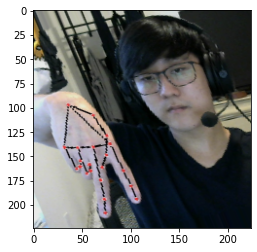

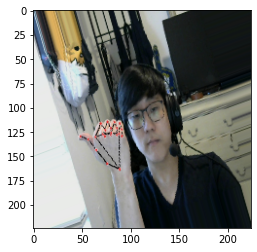

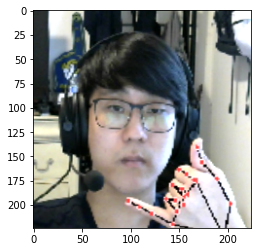

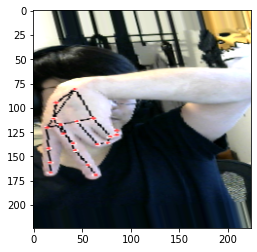

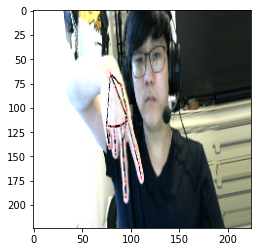

In [16]:
# Code from Noah Christiansen 
for _ in range(5):
    img, label = train_set.next()
    plt.imshow(img[0])
    plt.show()

## Basic Checks

In [11]:
# Check the class indicies the imageDataGenerator just made
train_set.class_indices

{'forward': 0,
 'play_pause': 1,
 'rewind': 2,
 'screenshot': 3,
 'volume_down': 4,
 'volume_up': 5}

In [12]:
# lets make sure the order and names are the same for both train and test
test_set.class_indices

{'forward': 0,
 'play_pause': 1,
 'rewind': 2,
 'screenshot': 3,
 'volume_down': 4,
 'volume_up': 5}

In [17]:
# Getting the input shape of the image to pass into the model
input_shape = train_set.image_shape
input_shape

(224, 224, 3)

<span id ='model'></span>
## MobileNet

In [102]:
mobile_net = MobileNet(include_top=False, input_shape = input_shape, pooling='avg')

In [94]:
mobile_net.trainable = False
model = Sequential()
model.add(mobile_net)
model.add(Dense(6, activation = 'softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['acc'])

# Step_size code from Noah Christiansen 
STEP_SIZE_TRAIN=train_set.n//train_set.batch_size
STEP_SIZE_VALID=test_set.n//test_set.batch_size

results = model.fit(train_set, epochs=10, verbose=1, validation_data=test_set, steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID)

Epoch 1/10
49/49 [==============================] - 17s 329ms/step - loss: 1.9480 - acc: 0.1684 - val_loss: 1.7679 - val_acc: 0.2431
Epoch 2/10
49/49 [==============================] - 15s 312ms/step - loss: 1.7579 - acc: 0.2584 - val_loss: 1.6268 - val_acc: 0.3264
Epoch 3/10
49/49 [==============================] - 15s 313ms/step - loss: 1.5950 - acc: 0.3540 - val_loss: 1.5102 - val_acc: 0.3958
Epoch 4/10
49/49 [==============================] - 15s 311ms/step - loss: 1.4374 - acc: 0.4638 - val_loss: 1.3489 - val_acc: 0.5000
Epoch 5/10
49/49 [==============================] - 15s 311ms/step - loss: 1.2770 - acc: 0.5581 - val_loss: 1.1886 - val_acc: 0.6042
Epoch 6/10
49/49 [==============================] - 15s 311ms/step - loss: 1.1813 - acc: 0.6305 - val_loss: 1.0776 - val_acc: 0.6944
Epoch 7/10
49/49 [==============================] - 15s 310ms/step - loss: 1.0908 - acc: 0.6783 - val_loss: 0.9904 - val_acc: 0.7431
Epoch 8/10
49/49 [==============================] - 15s 309ms/step - 

In [95]:
for layer in model.layers: 
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['acc'])
results = model.fit(train_set, epochs=15, verbose=1, validation_data=test_set, steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID,
                    callbacks=[ModelCheckpoint('../models/mobilenet.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')])

Epoch 1/15
49/49 [==============================] - ETA: 0s - loss: 0.3180 - acc: 0.9276
Epoch 00001: val_loss improved from inf to 0.15988, saving model to /content/drive/MyDrive/GA/Gesture Control/models/mobilenet.h5
49/49 [==============================] - 19s 339ms/step - loss: 0.3180 - acc: 0.9276 - val_loss: 0.1599 - val_acc: 0.9583
Epoch 2/15
49/49 [==============================] - ETA: 0s - loss: 0.0621 - acc: 0.9858
Epoch 00002: val_loss improved from 0.15988 to 0.05504, saving model to /content/drive/MyDrive/GA/Gesture Control/models/mobilenet.h5
49/49 [==============================] - 17s 339ms/step - loss: 0.0621 - acc: 0.9858 - val_loss: 0.0550 - val_acc: 0.9931
Epoch 3/15
49/49 [==============================] - ETA: 0s - loss: 0.0295 - acc: 0.9935
Epoch 00003: val_loss improved from 0.05504 to 0.03795, saving model to /content/drive/MyDrive/GA/Gesture Control/models/mobilenet.h5
49/49 [==============================] - 17s 342ms/step - loss: 0.0295 - acc: 0.9935 - val_

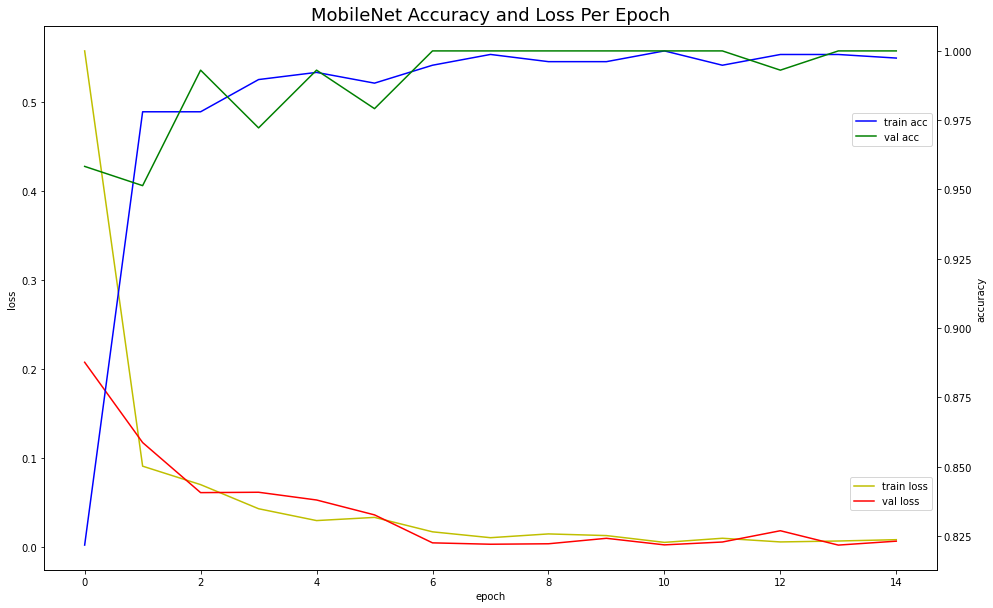

In [101]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc=4, bbox_to_anchor = (1,0.1))

acc_ax.plot(results.history['acc'], 'b', label='train acc')
acc_ax.plot(results.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc = 1, bbox_to_anchor = (1, 0.85))

plt.title('MobileNet Accuracy and Loss Per Epoch', size = 18)
plt.show()

> The `loss` and `val_loss` (on the left) goes down a fair ammount almost reaching 0  
> The `accuracy` and `val_accuracy` although different at the end, does have an intersection where both `accuracies` are at 1.00

<span id ='eval'></span>
## Load model to run tests

In [3]:
mn = load_model('../models/mobilenet.h5')

#### Checking with the test set and new images we have saved from notebook 1

In [4]:
rescale = ImageDataGenerator(rescale=1/255)
test_set_square = rescale.flow_from_directory('../imgs/test/',
                                   target_size=(224, 224),
                                   class_mode='categorical',
                                   batch_size= 1)

val_set_square = rescale.flow_from_directory('../imgs/collected/test_set_folders/test_set/',
                                   target_size=(224, 224),
                                   class_mode='categorical',
                                   batch_size= 1)

Found 144 images belonging to 6 classes.
Found 15 images belonging to 6 classes.


#### Evaluate both of them, checking the time it takes as well as `accuracy` and `loss`

In [5]:
mn.evaluate(test_set_square)
mn.evaluate(val_set_square)

15/15 [==============================] - 0s 27ms/step - loss: 0.0031 - acc: 1.0000: 0s - loss: 0.0018 - acc: 1.


[0.0031312007922679186, 1.0]

#### Code for function found on stackoverflow [here](https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels). Slight modifications were made, but post is by Amin Ullah


In [42]:
actions = ['forward', 'play_pause', 'rewind', 'screenshot', 'volume_down', 'volume_up']
def plot_confusion_matrix(y_test,y_scores,  title, classNames = actions):
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]/np.sum(cm[x,:])

    plt.figure(figsize=(10,10))
    sns.set(font_scale=1.5) # for label size
    df = sns.heatmap(con, annot=True,fmt='.2', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xticks(rotation = 45)
    plt.title(title, size = 24)
    df.figure.savefig("image2.png")

#### Confusion Matrix for `test_set_square`

**** Classification Report ****
              precision    recall  f1-score   support

     forward       1.00      1.00      1.00         3
  play_pause       1.00      1.00      1.00         3
      rewind       1.00      1.00      1.00         2
  screenshot       1.00      1.00      1.00         2
 volume_down       1.00      1.00      1.00         2
   volume_up       1.00      1.00      1.00         3

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



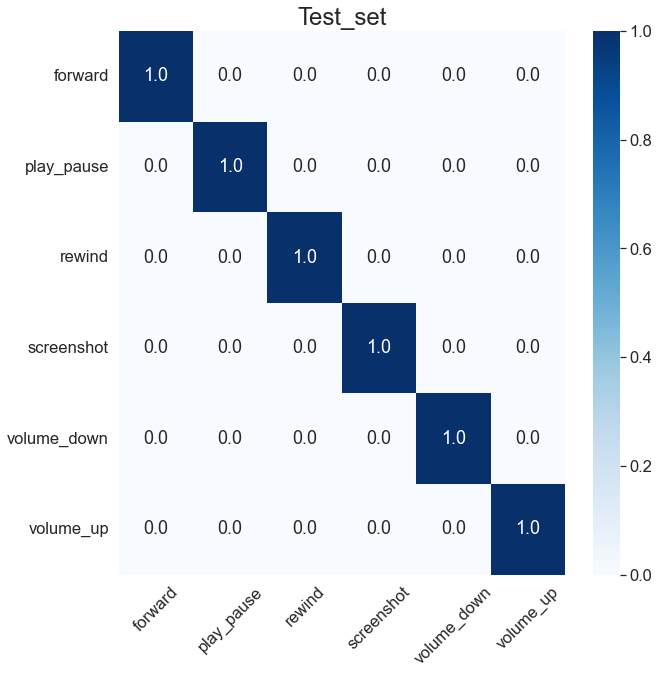

In [43]:
plot_confusion_matrix(y_true, preds, "Test_set")

> For all 6 classes, every single one of them was predicted correctly with no false positive or false negative

#### Confusion Matrix for `val_set_square`

**** Classification Report ****
              precision    recall  f1-score   support

     forward       1.00      1.00      1.00         3
  play_pause       1.00      1.00      1.00         3
      rewind       1.00      1.00      1.00         2
  screenshot       1.00      1.00      1.00         2
 volume_down       1.00      1.00      1.00         2
   volume_up       1.00      1.00      1.00         3

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



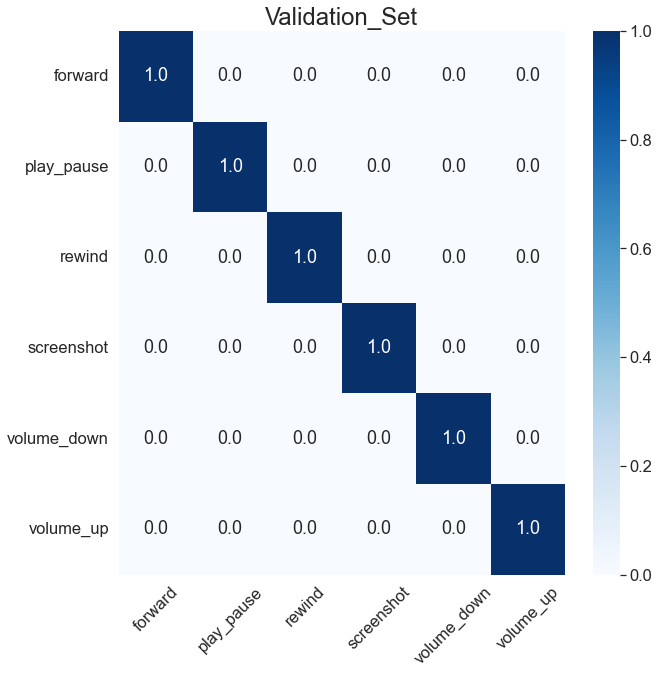

In [44]:
y_true = [val_set_square.classes[index] for index in val_set_square.index_array]
preds = np.argmax(mn.predict(val_set_square), axis = 1)

plot_confusion_matrix(y_true, preds, 'Validation_Set')

> For all 6 classes, every single one of them was predicted correctly with no false positive or false negative

#### List comprehension to just get the names of the files in the test_set

In [33]:
files = [f for f in listdir('../imgs/collected/test_set') if isfile(join('../imgs/collected/test_set', f))]
files

['forward_1.jpg',
 'forward_2.jpg',
 'forward_3.jpg',
 'pp_1.jpg',
 'pp_2.jpg',
 'pp_3.jpg',
 'rewind_1.jpg',
 'rewind_2.jpg',
 'ss_1.jpg',
 'ss_2.jpg',
 'vol-down_1.jpg',
 'vol-down_2.jpg',
 'vol-up_1.jpg',
 'vol-up_2.jpg',
 'vol-up_3.jpg']

#### How to resize cv2 images found [here](https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/)
<img src = './notebook_imgs/how_to_resize.png' width = "500" >

This is for the MobileNet model
-------------------------------


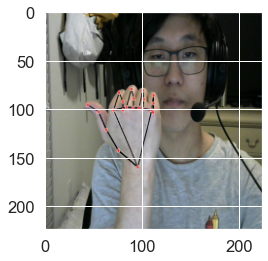

0.314 seconds to run
Picture is: forward
Prediction is: forward
Confidence: 0.9995170831680298
---------------------------------------------


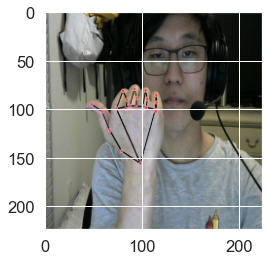

0.061 seconds to run
Picture is: forward
Prediction is: forward
Confidence: 0.9989919066429138
---------------------------------------------


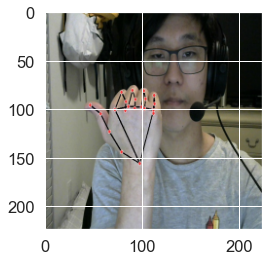

0.052 seconds to run
Picture is: forward
Prediction is: forward
Confidence: 0.9995664954185486
---------------------------------------------


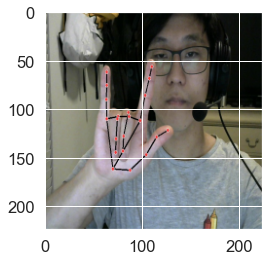

0.059 seconds to run
Picture is: pp
Prediction is: play_pause
Confidence: 0.9573161005973816
---------------------------------------------


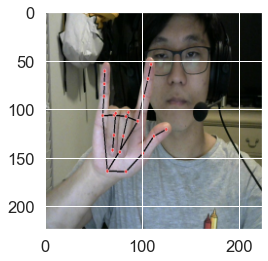

0.062 seconds to run
Picture is: pp
Prediction is: play_pause
Confidence: 0.966025710105896
---------------------------------------------


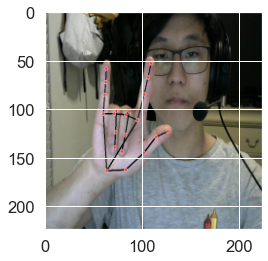

0.055 seconds to run
Picture is: pp
Prediction is: play_pause
Confidence: 0.9668229222297668
---------------------------------------------


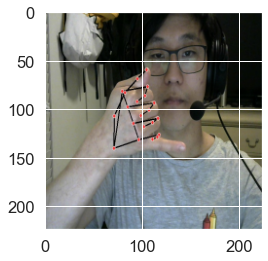

0.056 seconds to run
Picture is: rewind
Prediction is: rewind
Confidence: 0.9828155636787415
---------------------------------------------


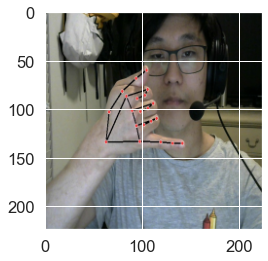

0.234 seconds to run
Picture is: rewind
Prediction is: rewind
Confidence: 0.9970105886459351
---------------------------------------------


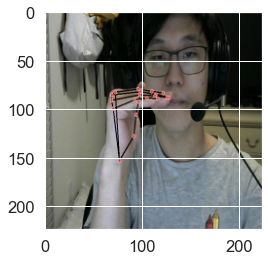

0.052 seconds to run
Picture is: ss
Prediction is: screenshot
Confidence: 0.9934548735618591
---------------------------------------------


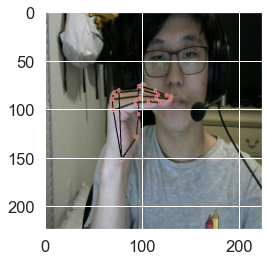

0.053 seconds to run
Picture is: ss
Prediction is: screenshot
Confidence: 0.9963395595550537
---------------------------------------------


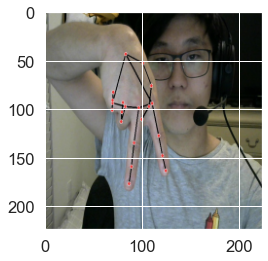

0.069 seconds to run
Picture is: vol-down
Prediction is: volume_down
Confidence: 0.9999445676803589
---------------------------------------------


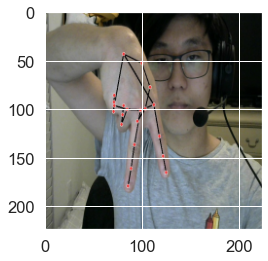

0.057 seconds to run
Picture is: vol-down
Prediction is: volume_down
Confidence: 0.9999047517776489
---------------------------------------------


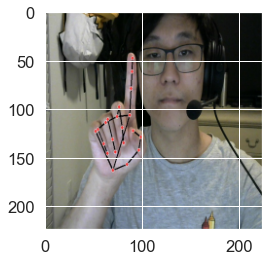

0.053 seconds to run
Picture is: vol-up
Prediction is: volume_up
Confidence: 0.9901723861694336
---------------------------------------------


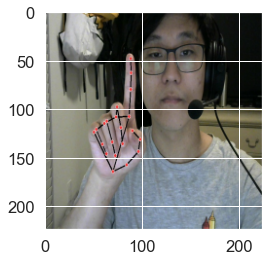

0.06 seconds to run
Picture is: vol-up
Prediction is: volume_up
Confidence: 0.9895167946815491
---------------------------------------------


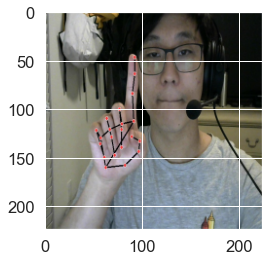

0.063 seconds to run
Picture is: vol-up
Prediction is: volume_up
Confidence: 0.9957774877548218
---------------------------------------------


In [34]:
print('This is for the MobileNet model')
print('-------------------------------')
for file in files:
    test = cv2.imread(f'../imgs/collected/test_set/{file}')
    test =  cv2.resize(test, (224,224), interpolation = cv2.INTER_AREA) # Adapted from image above
    image = cv2.cvtColor(test, cv2.COLOR_RGB2BGR)
    plt.imshow(image)
    plt.show()
    t0 = time.time()
    pred_prob = mn.predict(test.reshape(1, 224, 224, 3)/255)
    pred = actions[np.argmax(pred_prob)] # actions was defined in the plot_confusion_matrix function cell
    print(f'{round(time.time() - t0,3)} seconds to run')
    print(f"Picture is: {file.split('_')[0]}\nPrediction is: {pred}")
    print(f'Confidence: {np.max(pred_prob)}')
    print('---'*15)

> Every Single image was correctly predicted showing that this model is now ready for a webcam 